## Initializing

### Loading library 

In [120]:
library(dplyr)
library(ggplot2)
library(haven)
library(hrbrthemes)
library(reshape2)
library(rpart)
library(rpart.plot)


### Importing data and merging data

In [121]:
DQdata <- read_xpt("data/P_DIQ.XPT")
BMdata <- read_xpt("data/P_BMX.XPT")
BPdata <- read_xpt("data/P_BPQ.XPT")
AUdata <- read_xpt("data/P_ALQ.XPT")

DQdata_selected <- select(DQdata, SEQN, DIQ010)
BMdata_selected <- select(BMdata, SEQN, BMXWT, BMXHT, BMXWAIST, BMXHIP, BMXBMI)
BMdata_selected <- subset(BMdata_selected, is.na(BMdata$BMIWT) & is.na(BMdata$BMIHT))
BPdata_selected <- select(BPdata, SEQN, BPQ020, BPQ080)
AUdata_selected <- select(AUdata, SEQN, ALQ121, ALQ130)

OtData_selected <- merge(DQdata_selected, BMdata_selected, by = "SEQN", all.x = TRUE)
OtData_selected <- merge(OtData_selected, BPdata_selected, by = "SEQN", all.x = TRUE)
OtData_selected <- merge(OtData_selected, AUdata_selected, by = "SEQN", all.x = TRUE)
OtData_selected <- na.omit(OtData_selected)

summary(OtData_selected)

      SEQN            DIQ010          BMXWT            BMXHT      
 Min.   :109266   Min.   :1.000   Min.   : 36.80   Min.   :141.1  
 1st Qu.:113266   1st Qu.:2.000   1st Qu.: 68.50   1st Qu.:160.8  
 Median :117177   Median :2.000   Median : 81.10   Median :167.7  
 Mean   :117170   Mean   :1.911   Mean   : 84.41   Mean   :168.0  
 3rd Qu.:121130   3rd Qu.:2.000   3rd Qu.: 96.70   3rd Qu.:175.1  
 Max.   :124822   Max.   :9.000   Max.   :223.50   Max.   :199.6  
    BMXWAIST         BMXHIP          BMXBMI          BPQ020         BPQ080     
 Min.   : 61.1   Min.   : 74.0   Min.   :14.60   Min.   :1.00   Min.   :1.000  
 1st Qu.: 87.9   1st Qu.: 97.3   1st Qu.:24.70   1st Qu.:1.00   1st Qu.:1.000  
 Median : 98.9   Median :104.9   Median :28.70   Median :2.00   Median :2.000  
 Mean   :100.3   Mean   :107.4   Mean   :29.84   Mean   :1.67   Mean   :1.723  
 3rd Qu.:111.0   3rd Qu.:114.7   3rd Qu.:33.60   3rd Qu.:2.00   3rd Qu.:2.000  
 Max.   :187.5   Max.   :187.5   Max.   :82.00   Ma

### Data transformation and filtering

In [122]:
OtData_selected <- subset(OtData_selected, OtData_selected$DIQ010 < 3)
OtData_selected <- transform(OtData_selected, DIQ010 = ifelse(DIQ010 > 1, 0, 1))
OtData_selected <- subset(OtData_selected, OtData_selected$BPQ020 < 3 & OtData_selected$BPQ080 < 3)
OtData_selected <- transform(OtData_selected, BPQ020 = ifelse(BPQ020 > 1, 0, 1))
OtData_selected <- transform(OtData_selected, BPQ080 = ifelse(BPQ080 > 1, 0, 1))
OtData_selected <- subset(OtData_selected, OtData_selected$ALQ121 < 11 & OtData_selected$ALQ130 < 16)

Overweight <- ifelse(OtData_selected$BMXWT / (OtData_selected$BMXHT / 100)^2 > 25.0, 1, 0)
OtData_selected$Overweight <- Overweight

summary(OtData_selected)

      SEQN            DIQ010          BMXWT            BMXHT      
 Min.   :109266   Min.   :0.000   Min.   : 36.80   Min.   :141.1  
 1st Qu.:113264   1st Qu.:0.000   1st Qu.: 68.30   1st Qu.:160.8  
 Median :117152   Median :0.000   Median : 81.00   Median :167.7  
 Mean   :117158   Mean   :0.119   Mean   : 84.22   Mean   :168.0  
 3rd Qu.:121116   3rd Qu.:0.000   3rd Qu.: 96.40   3rd Qu.:175.0  
 Max.   :124822   Max.   :1.000   Max.   :210.80   Max.   :199.6  
    BMXWAIST          BMXHIP           BMXBMI          BPQ020      
 Min.   : 61.10   Min.   : 74.00   Min.   :14.60   Min.   :0.0000  
 1st Qu.: 87.60   1st Qu.: 97.28   1st Qu.:24.70   1st Qu.:0.0000  
 Median : 98.65   Median :104.90   Median :28.60   Median :0.0000  
 Mean   :100.08   Mean   :107.31   Mean   :29.77   Mean   :0.3266  
 3rd Qu.:110.92   3rd Qu.:114.60   3rd Qu.:33.50   3rd Qu.:1.0000  
 Max.   :178.00   Max.   :187.50   Max.   :82.00   Max.   :1.0000  
     BPQ080           ALQ121           ALQ130         O

## Data accuracy testing

### Linear regression model for BMI ~ Calculated BMI

In [123]:
HvsBMI.lm <- lm(BMXBMI ~ I(BMXWT / (BMXHT / 100)^2), data = OtData_selected)
summary(HvsBMI.lm)


Call:
lm(formula = BMXBMI ~ I(BMXWT/(BMXHT/100)^2), data = OtData_selected)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.050214 -0.024855 -0.000059  0.024914  0.049759 

Coefficients:
                        Estimate Std. Error   t value Pr(>|t|)    
(Intercept)            0.0004068  0.0016368     0.249    0.804    
I(BMXWT/(BMXHT/100)^2) 0.9999925  0.0000534 18725.280   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02875 on 5426 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.506e+08 on 1 and 5426 DF,  p-value: < 2.2e-16


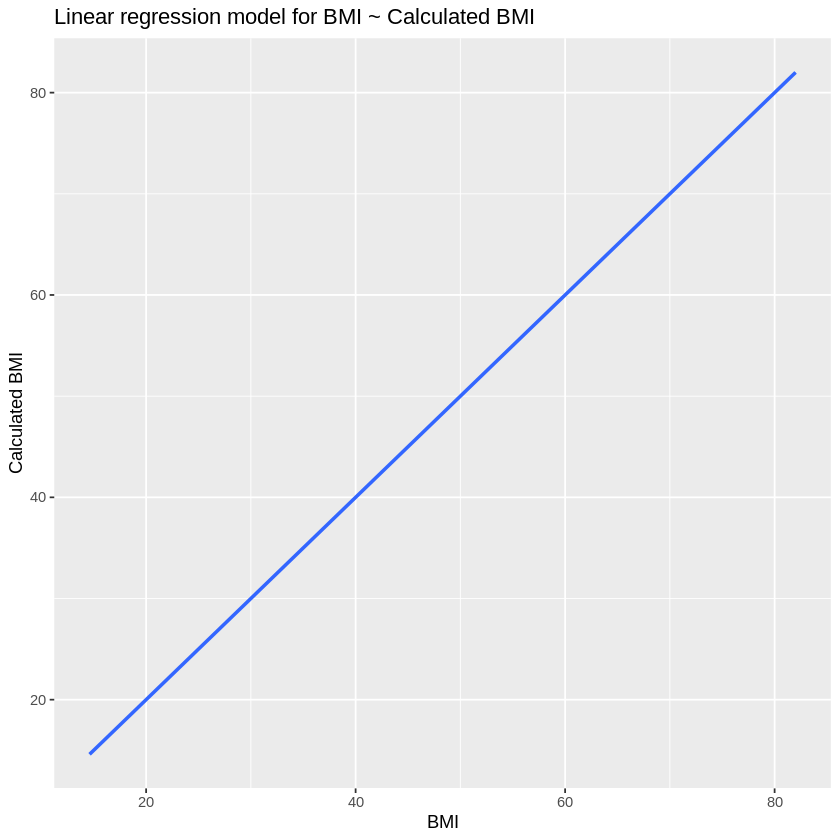

In [124]:
ggplot(OtData_selected, aes(BMXBMI, I(BMXWT / (BMXHT / 100)^2))) +
    geom_smooth(method="lm", formula = y ~ x) +
    labs(x='BMI', y='Calculated BMI', title='Linear regression model for BMI ~ Calculated BMI')

## Data overview

### Distribution of body weight

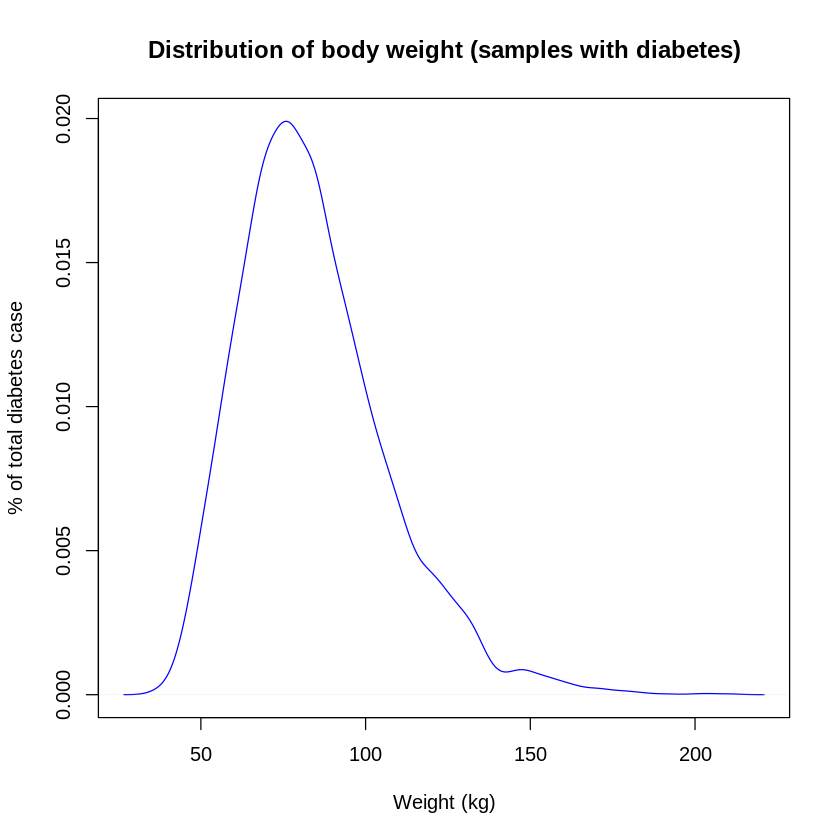

In [125]:
plot(density(OtData_selected$BMXWT), main = "Distribution of body weight (samples with diabetes)", xlab = "Weight (kg)", ylab = "% of total diabetes case", col = "Blue")

### Distribution of body height

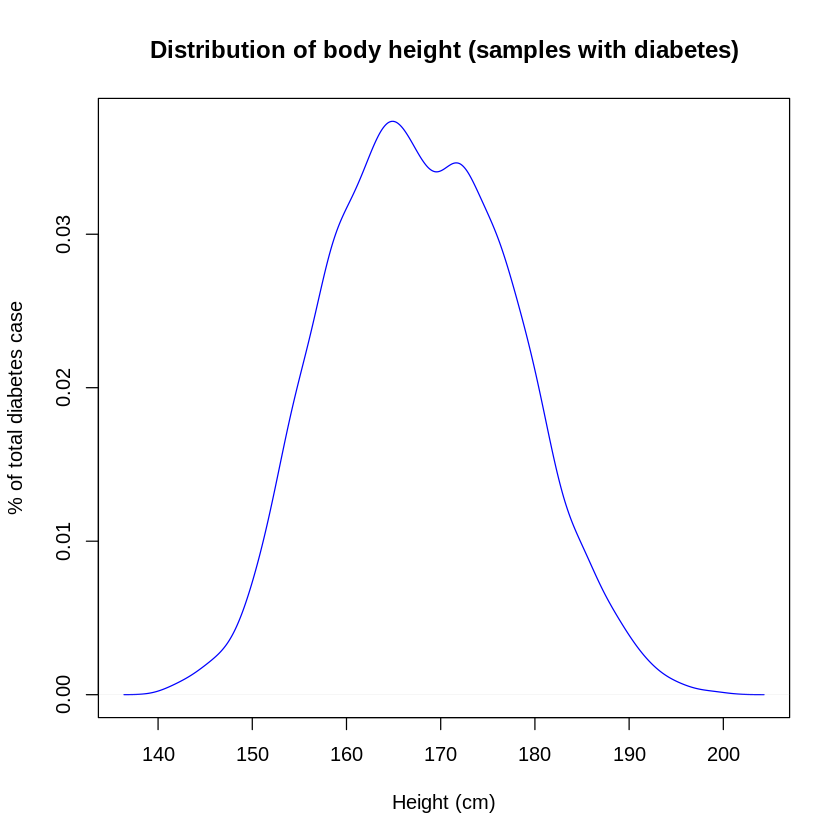

In [126]:
plot(density(OtData_selected$BMXHT), main = "Distribution of body height (samples with diabetes)", xlab = "Height (cm)", ylab = "% of total diabetes case", col = "Blue")

### Distribution of Waist Circumference

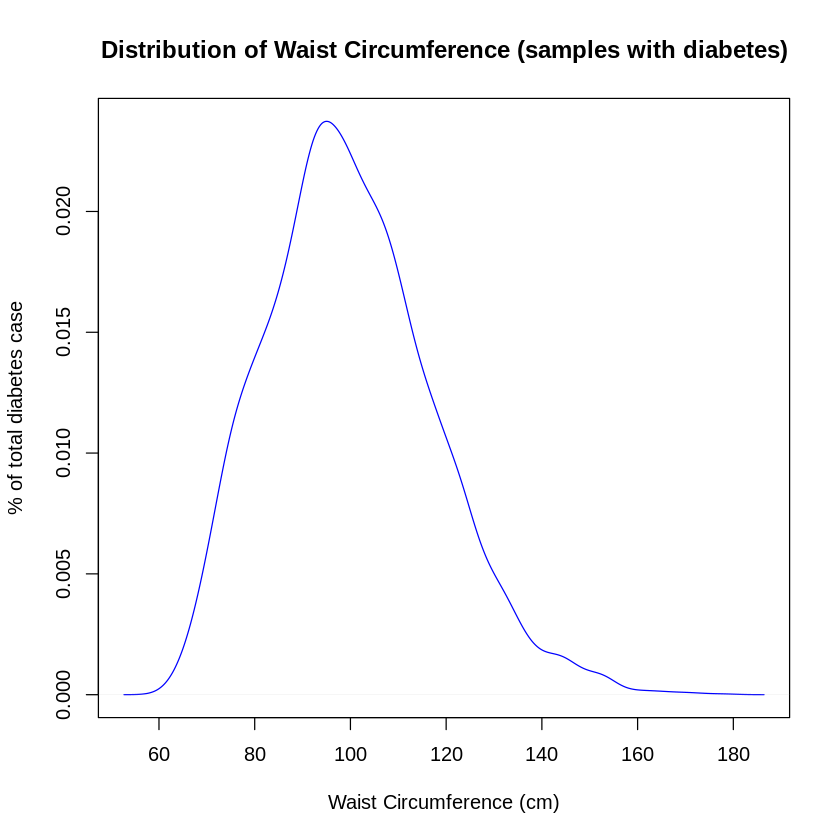

In [127]:
plot(density(OtData_selected$BMXWAIST), main = "Distribution of Waist Circumference (samples with diabetes)", xlab = "Waist Circumference (cm)", ylab = "% of total diabetes case", col = "Blue")

### Distribution of Hip Circumference

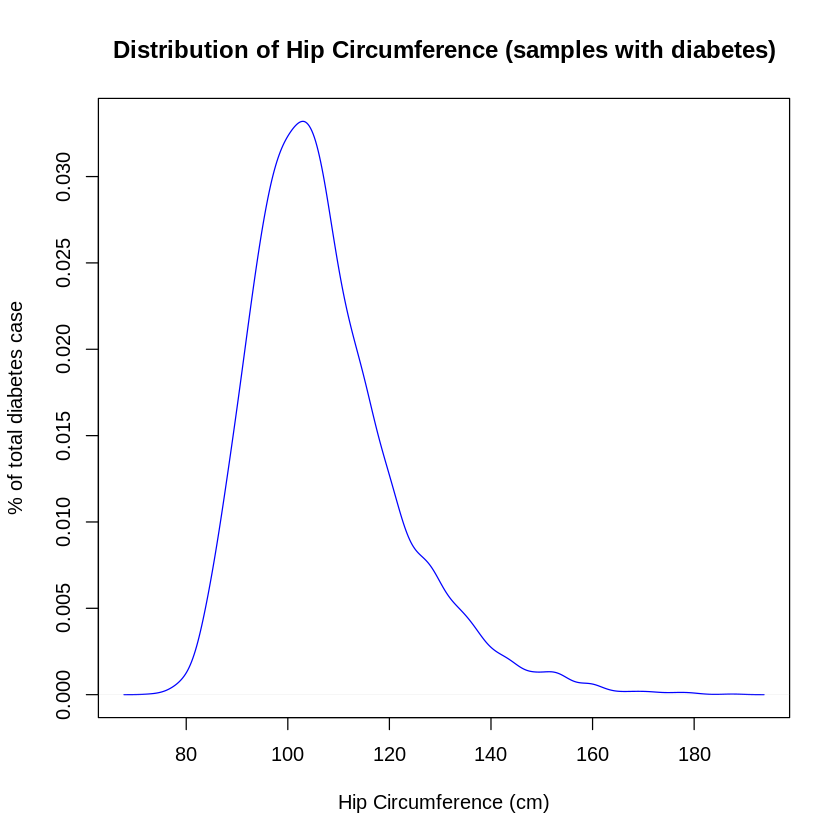

In [128]:
plot(density(OtData_selected$BMXHIP), main = "Distribution of Hip Circumference (samples with diabetes)", xlab = "Hip Circumference (cm)", ylab = "% of total diabetes case", col = "Blue")

### Histogram of BMI

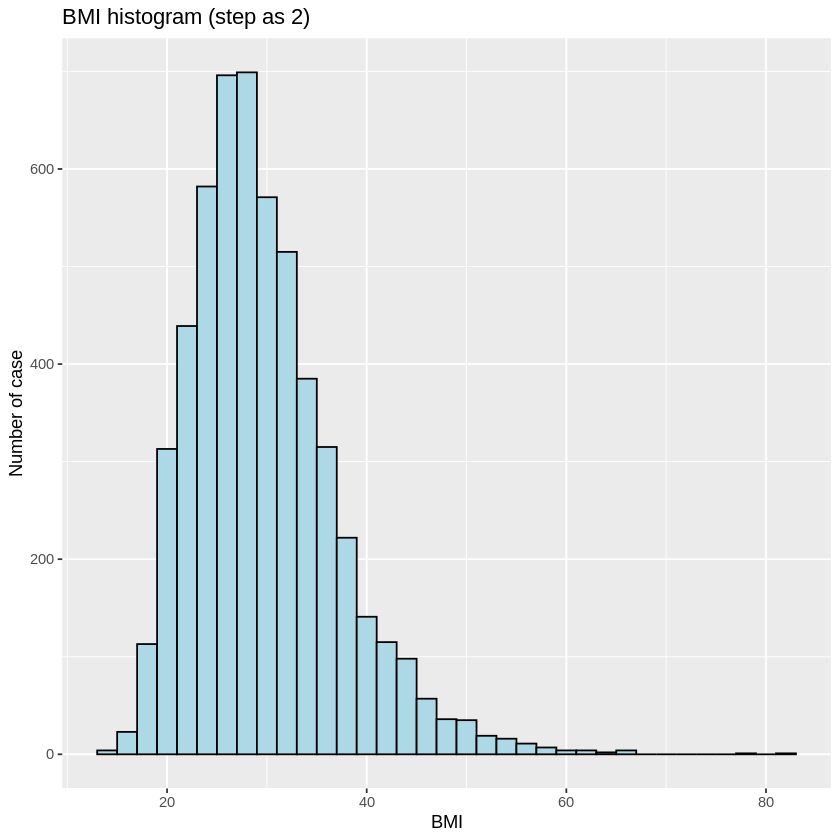

In [129]:
ggplot(OtData_selected, aes(x = BMXBMI)) +
    geom_histogram(binwidth = 2, col = "black", fill = "lightblue") +
    labs(title = "BMI histogram (step as 2)", x = "BMI", y = "Number of case")

## Data analysing

### Correlation heatmap

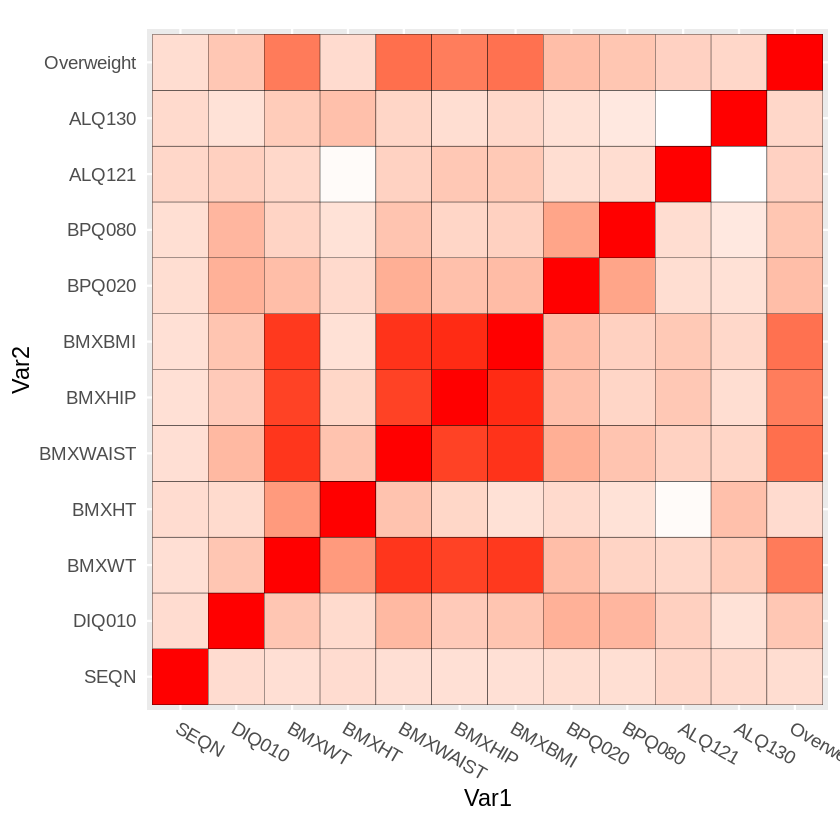

In [130]:
meltCor <- melt(round(cor(OtData_selected), 10))
ggplot(data = meltCor, aes(x=Var1, y=Var2, fill=value)) + 
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "red") +
    coord_fixed() + 
    theme_ipsum() +
    theme_grey(base_size = 14) + 
    theme(legend.position = "none",
        axis.ticks = element_blank(), 
        axis.text.x = element_text(angle = 330, hjust = 0))

### Peason correlation test on Height ~ BMI and Weight ~ BMI

In [131]:
HvsBMI.res <- cor.test(OtData_selected$BMXBMI, OtData_selected$BMXHT, method = "pearson")
HvsBMI.res

HvsBMI.res <- cor.test(OtData_selected$BMXBMI, OtData_selected$BMXWT, method = "pearson")
HvsBMI.res


	Pearson's product-moment correlation

data:  OtData_selected$BMXBMI and OtData_selected$BMXHT
t = -2.4617, df = 5426, p-value = 0.01386
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.059951509 -0.006802975
sample estimates:
        cor 
-0.03340086 



	Pearson's product-moment correlation

data:  OtData_selected$BMXBMI and OtData_selected$BMXWT
t = 146.25, df = 5426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8876029 0.8983752
sample estimates:
      cor 
0.8931171 


In [132]:
HvsBMI.res <- cor.test(OtData_selected$BMXWAIST, OtData_selected$BMXHT, method = "pearson")
HvsBMI.res

HvsBMI.res <- cor.test(OtData_selected$BMXHIP, OtData_selected$BMXWT, method = "pearson")
HvsBMI.res


	Pearson's product-moment correlation

data:  OtData_selected$BMXWAIST and OtData_selected$BMXHT
t = 11.55, df = 5426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1288336 0.1807656
sample estimates:
      cor 
0.1549066 



	Pearson's product-moment correlation

data:  OtData_selected$BMXHIP and OtData_selected$BMXWT
t = 124.64, df = 5426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8538496 0.8676300
sample estimates:
      cor 
0.8608976 


### Logistic regression model for Diabetes ~ BMI + Waist Circumference

In [133]:
print("Logistic regression model for Diabetes ~ BMI + Waist Circumference")
glm1 <- glm(formula = DIQ010 ~ BMXBMI + BMXWAIST, family = binomial(link = "logit"), data = OtData_selected)
summary(glm1)

[1] "Logistic regression model for Diabetes ~ BMI + Waist Circumference"



Call:
glm(formula = DIQ010 ~ BMXBMI + BMXWAIST, family = binomial(link = "logit"), 
    data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7834  -0.5330  -0.4000  -0.2877   2.6825  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.357782   0.314908 -23.365   <2e-16 ***
BMXBMI      -0.138204   0.014418  -9.586   <2e-16 ***
BMXWAIST     0.092273   0.006203  14.876   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3609.4  on 5425  degrees of freedom
AIC: 3615.4

Number of Fisher Scoring iterations: 5


### Logistic regression model for Diabetes ~ Overweight

In [134]:
print("Logistic regression model for Diabetes ~ Overweight")
glm2 <- glm(formula = DIQ010 ~ Overweight, family = binomial(link = "logit"), data = OtData_selected)
summary(glm2)

[1] "Logistic regression model for Diabetes ~ Overweight"



Call:
glm(formula = DIQ010 ~ Overweight, family = binomial(link = "logit"), 
    data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5592  -0.5592  -0.5592  -0.3163   2.4577  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.9701     0.1217 -24.409   <2e-16 ***
Overweight    1.1935     0.1298   9.197   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3852.6  on 5426  degrees of freedom
AIC: 3856.6

Number of Fisher Scoring iterations: 5


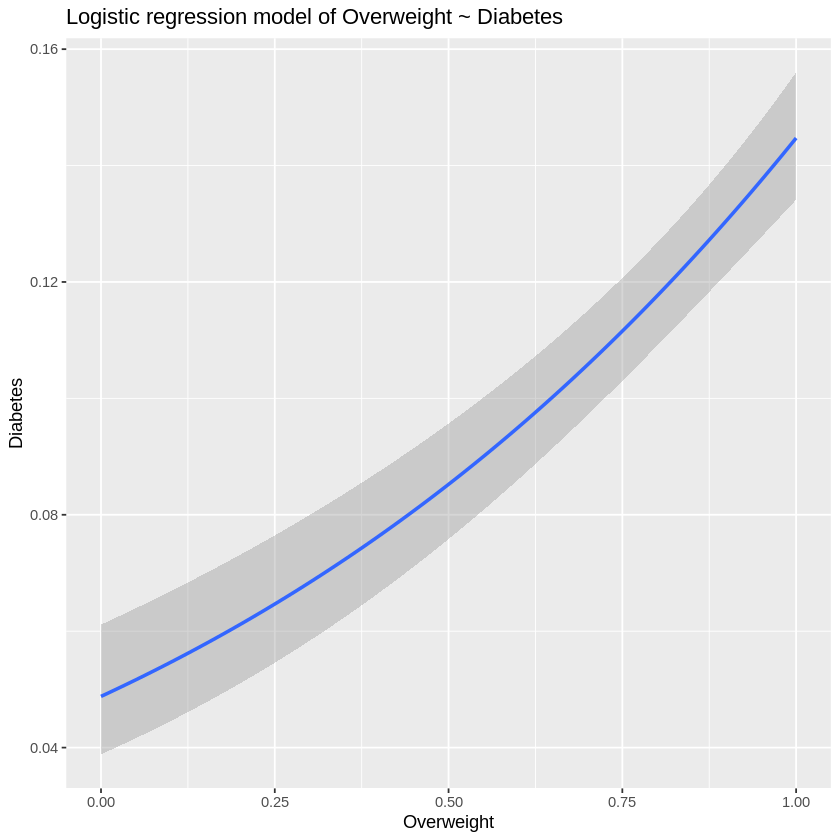

In [135]:
ggplot(OtData_selected, aes(Overweight, DIQ010)) +
    geom_smooth(method="glm", method.args = list(family = "binomial"), formula = y ~ x) +
    labs(x='Overweight', y='Diabetes', title='Logistic regression model of Overweight ~ Diabetes')

### Logistic regression model for Diabetes ~ Cholesterol level

In [136]:
print("Logistic regression model for Diabetes ~ Cholesterol level")
glm3 <- glm(formula = DIQ010 ~ BPQ080, family = binomial(link = "logit"), data = OtData_selected)
summary(glm3)

[1] "Logistic regression model for Diabetes ~ Cholesterol level"



Call:
glm(formula = DIQ010 ~ BPQ080, family = binomial(link = "logit"), 
    data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7279  -0.3721  -0.3721  -0.3721   2.3258  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.6353     0.0656  -40.17   <2e-16 ***
BPQ080        1.4422     0.0871   16.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3678.9  on 5426  degrees of freedom
AIC: 3682.9

Number of Fisher Scoring iterations: 5


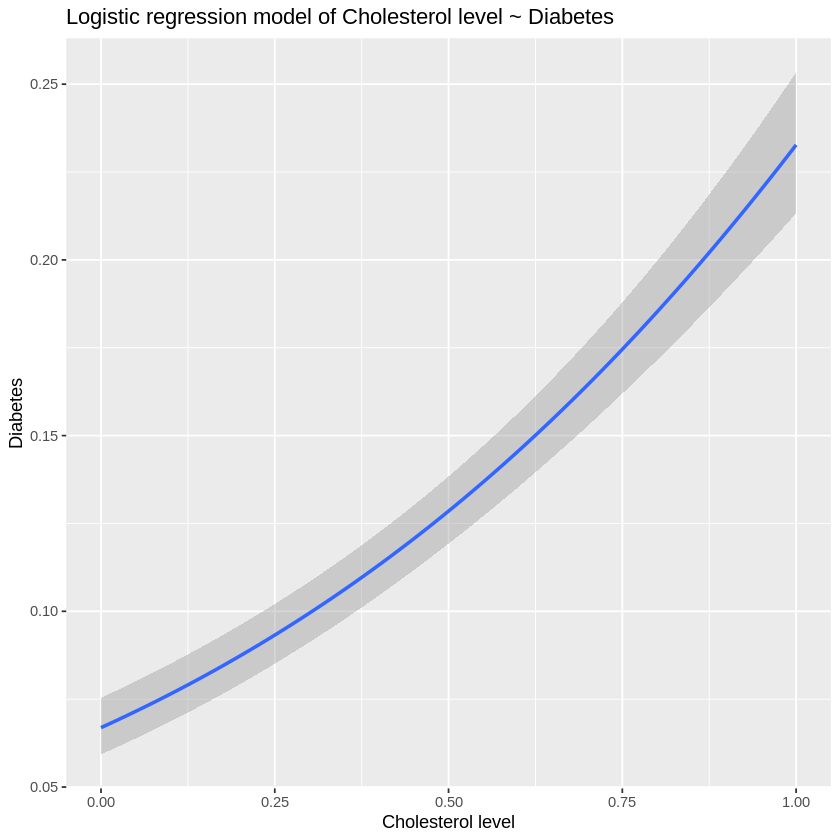

In [137]:
ggplot(OtData_selected, aes(BPQ080, DIQ010)) +
    geom_smooth(method="glm", method.args = list(family = "binomial"), formula = y ~ x) +
    labs(x='Cholesterol level', y='Diabetes', title='Logistic regression model of Cholesterol level ~ Diabetes')

### Logistic regression model for Diabetes ~ High blood pressure

In [138]:
print("Logistic regression model for Diabetes ~ High blood pressure")
glm4 <- glm(formula = DIQ010 ~ BPQ020, family = binomial(link = "logit"), data = OtData_selected)
summary(glm4)

[1] "Logistic regression model for Diabetes ~ High blood pressure"



Call:
glm(formula = DIQ010 ~ BPQ020, family = binomial(link = "logit"), 
    data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7493  -0.3457  -0.3457  -0.3457   2.3863  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.78751    0.07076  -39.39   <2e-16 ***
BPQ020       1.66088    0.08977   18.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3592.2  on 5426  degrees of freedom
AIC: 3596.2

Number of Fisher Scoring iterations: 5


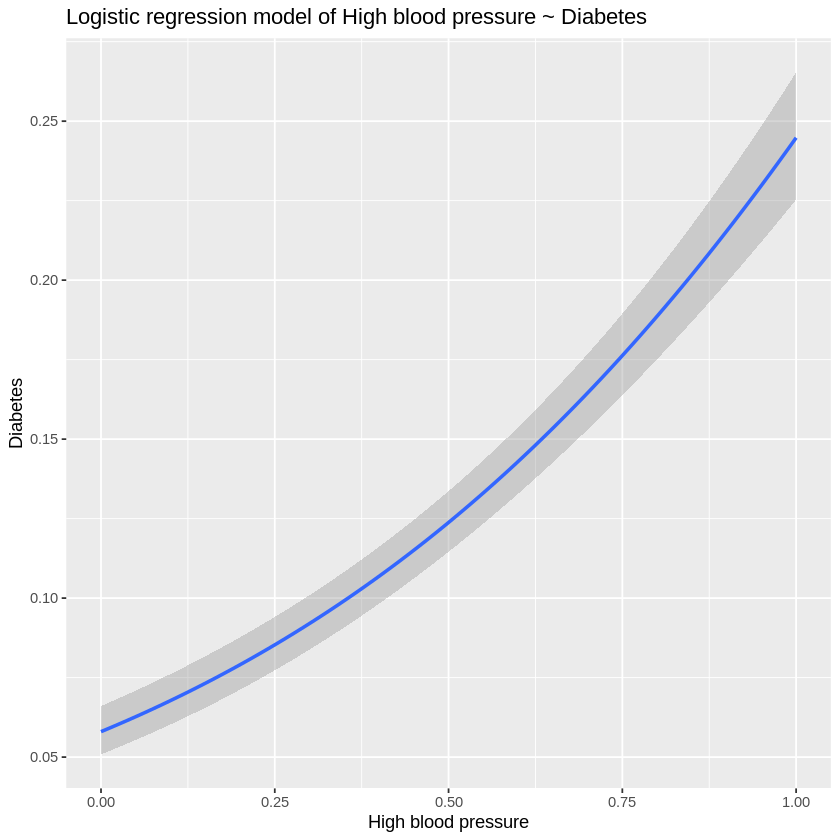

In [139]:
ggplot(OtData_selected, aes(BPQ020, DIQ010)) +
    geom_smooth(method="glm", method.args = list(family = "binomial"), formula = y ~ x) +
    labs(x='High blood pressure', y='Diabetes', title='Logistic regression model of High blood pressure ~ Diabetes')

### Logistic regression model of Avg # alcoholic drinks/day ~ Diabetes

In [140]:
print("Logistic regression model of Avg # alcoholic drinks/day ~ Diabetes")
glm5 <- glm(formula = DIQ010 ~ ALQ130, family = binomial(link = "logit"), data = OtData_selected)
summary(glm5)

[1] "Logistic regression model of Avg # alcoholic drinks/day ~ Diabetes"



Call:
glm(formula = DIQ010 ~ ALQ130, family = binomial(link = "logit"), 
    data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5265  -0.5265  -0.5103  -0.4794   2.4057  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.83975    0.06819 -26.980  < 2e-16 ***
ALQ130      -0.06647    0.02297  -2.894  0.00381 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3952.7  on 5426  degrees of freedom
AIC: 3956.7

Number of Fisher Scoring iterations: 5


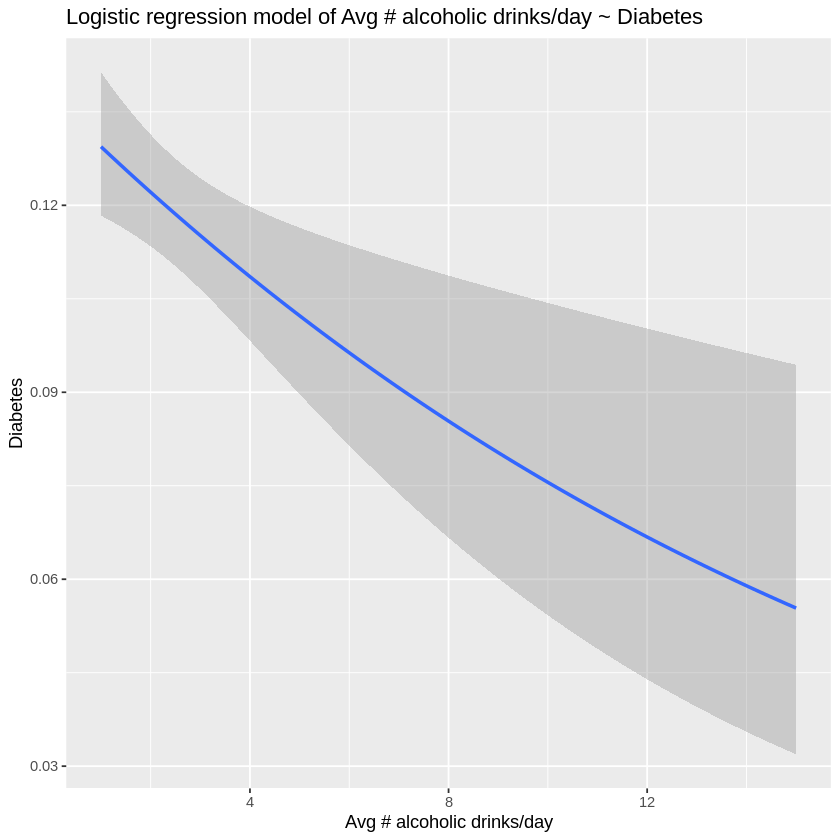

In [141]:
ggplot(OtData_selected, aes(ALQ130, DIQ010)) +
    geom_smooth(method="glm", method.args = list(family = "binomial"), formula = y ~ x) +
    labs(x='Avg # alcoholic drinks/day', y='Diabetes', title='Logistic regression model of Avg # alcoholic drinks/day ~ Diabetes')

### Pearson correlation test on BMI ~ Diabetes

In [142]:
DvsBMI.res <- cor.test(OtData_selected$BMXBMI, OtData_selected$DIQ010, method = "pearson")
print(DvsBMI.res)


	Pearson's product-moment correlation

data:  OtData_selected$BMXBMI and OtData_selected$DIQ010
t = 10.935, df = 5426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1207105 0.1727718
sample estimates:
      cor 
0.1468428 



### Logistic regression model of BMI ~ Diabetes

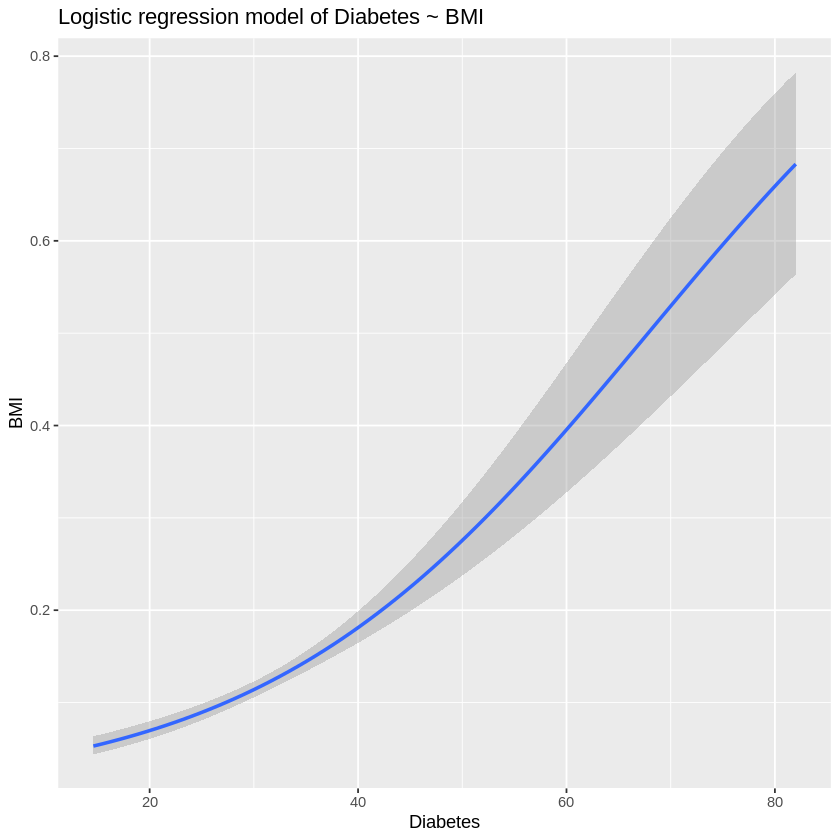

In [143]:
ggplot(OtData_selected, aes(BMXBMI, DIQ010)) +
    geom_smooth(method="glm", method.args = list(family = "binomial"), formula = y ~ x) +
    labs(x='Diabetes', y='BMI', title='Logistic regression model of Diabetes ~ BMI')

### Boxplot of Diabetes & Avg # alcoholic drinks/day

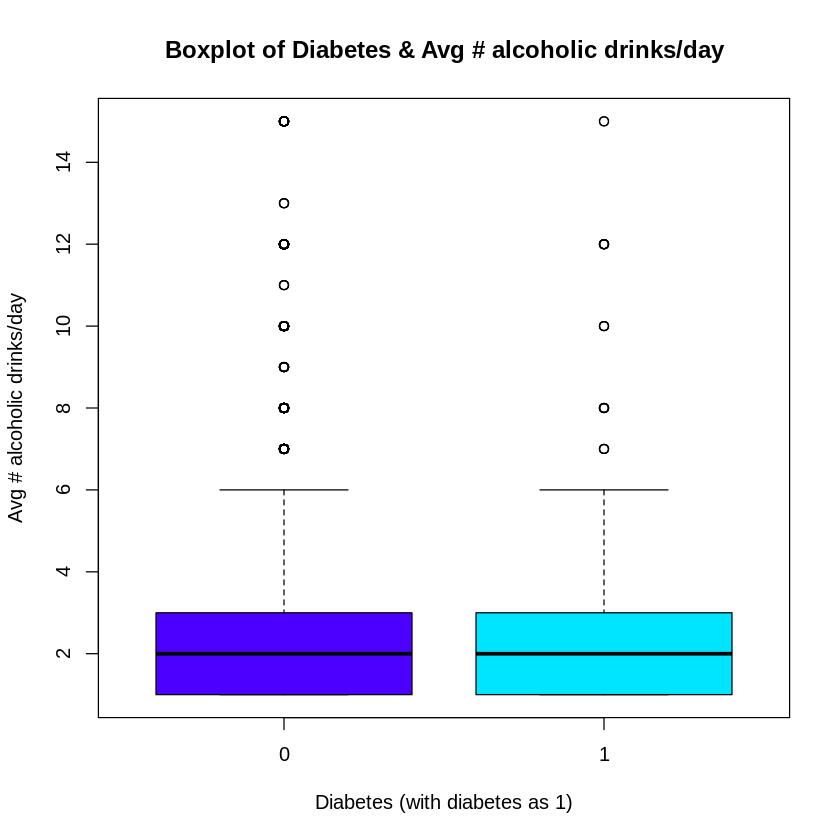

In [144]:
boxplot(ALQ130 ~ DIQ010, data = OtData_selected, main = "Boxplot of Diabetes & Avg # alcoholic drinks/day", xlab = "Diabetes (with diabetes as 1)", ylab = "Avg # alcoholic drinks/day", col = topo.colors(2))

### Boxplot on Diabetes and BMI

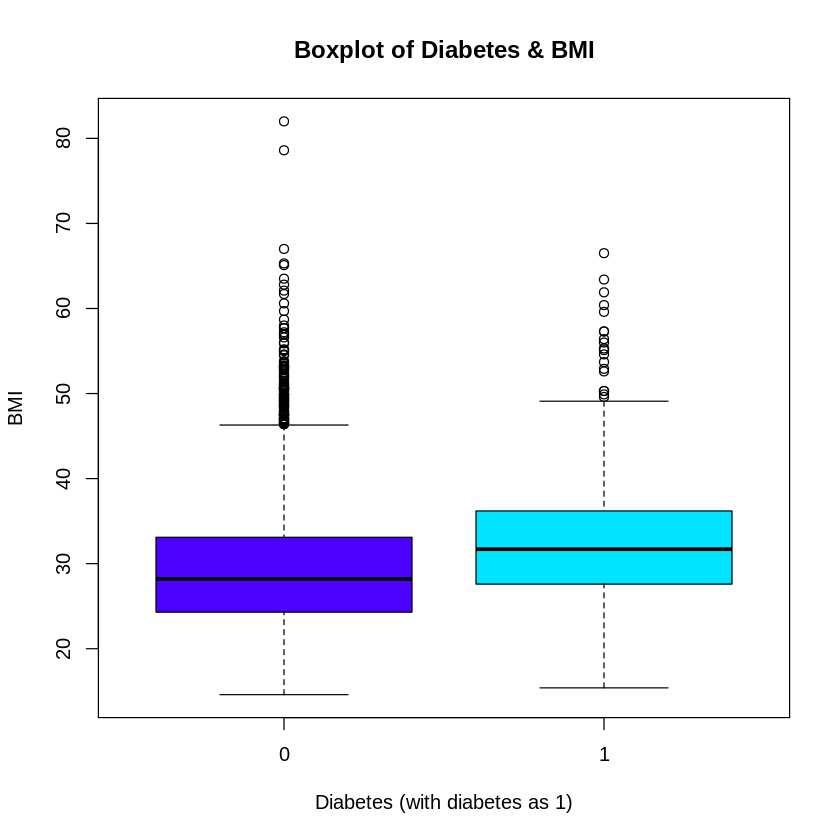

In [145]:
boxplot(BMXBMI ~ DIQ010, data = OtData_selected, main = "Boxplot of Diabetes & BMI", xlab = "Diabetes (with diabetes as 1)", ylab = "BMI", col = topo.colors(2))

### Logistic regression model for Diabetes

In [146]:
print("Logistic regression model for Diabetes")
glm8 <- glm(formula = DIQ010 ~ BMXWAIST + BMXHIP + BMXBMI + BPQ020 + BPQ080 + ALQ130, family = binomial(link = "logit"), data = OtData_selected)
summary(glm8)

[1] "Logistic regression model for Diabetes"



Call:
glm(formula = DIQ010 ~ BMXWAIST + BMXHIP + BMXBMI + BPQ020 + 
    BPQ080 + ALQ130, family = binomial(link = "logit"), data = OtData_selected)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6522  -0.4936  -0.3088  -0.1972   2.9010  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.445738   0.525961  -8.453  < 2e-16 ***
BMXWAIST     0.077596   0.006728  11.533  < 2e-16 ***
BMXHIP      -0.057188   0.008747  -6.538 6.24e-11 ***
BMXBMI      -0.004052   0.020098  -0.202  0.84023    
BPQ020       1.021170   0.098285  10.390  < 2e-16 ***
BPQ080       0.883811   0.096445   9.164  < 2e-16 ***
ALQ130      -0.077706   0.024492  -3.173  0.00151 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3961.9  on 5427  degrees of freedom
Residual deviance: 3248.5  on 5421  degrees of freedom
AIC: 3262.5

Number of Fisher Scoring iterations: 6


### Decision tree

In [147]:
tree <- rpart(DIQ010 ~., data = OtData_selected)
printcp(tree)


Regression tree:
rpart(formula = DIQ010 ~ ., data = OtData_selected)

Variables actually used in tree construction:
[1] BMXWAIST BPQ020   BPQ080  

Root node error: 569.12/5428 = 0.10485

n= 5428 

        CP nsplit rel error  xerror     xstd
1 0.073184      0   1.00000 1.00037 0.031952
2 0.023153      1   0.92682 0.92752 0.028443
3 0.010094      2   0.90366 0.91105 0.028286
4 0.010000      3   0.89357 0.91367 0.028455


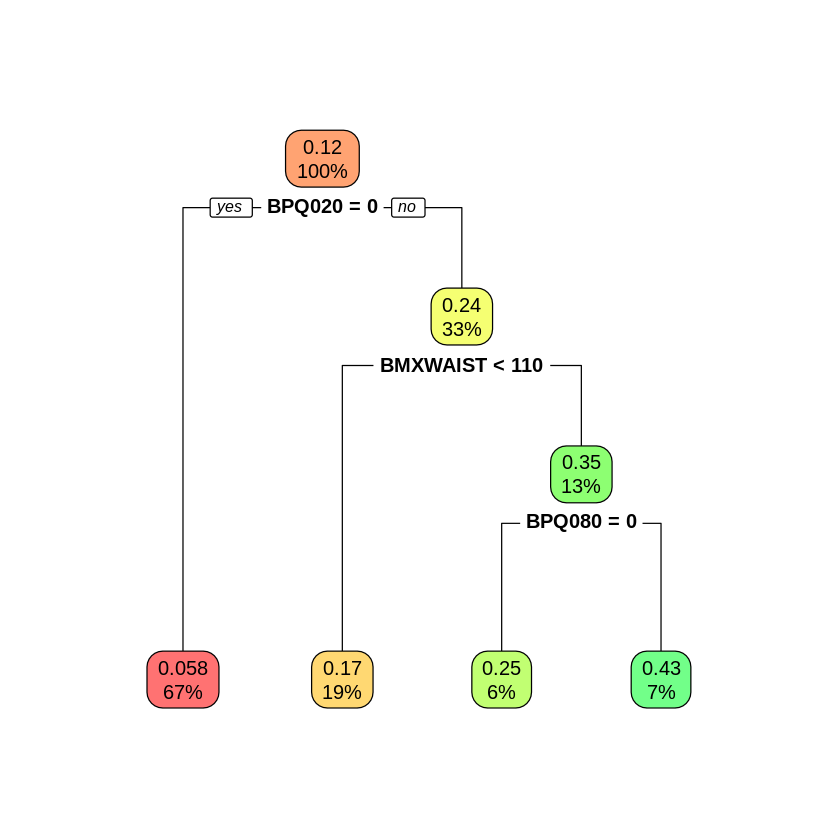

In [148]:
rpart.plot(tree, box.palette = "RdYlGn")